In [1]:
########## SECTION 1 - Importing Required Packages and Functions ###############################
import pandas as pd
import numpy as np 
import time
from simulate import generateData
from linear_programs import checkMleExistence

In [2]:
########## SECTION 2 - Generating Simulated Dataset ############################################

# number of observations
n=40000

# number of (Gaussian) covariates
p=200

# Gaussian covariate distribution parameters
# NOTE: MAY WANT TO GO BACK AND REDO SIMULATION CODE TO GENERATE DATA DIRECTLY FROM MULTIVARIATE NORMAL
mu = 0
stdev = 1.0/np.sqrt(n) #signal strength
# NOTE: Added a scaling factor to stdev

# Generate the data
# - X is an (n,p+1) dimensional array with the n rows corresponding to observations and the p+1 columns
#   corresponding to the covariates + a column of 1's (for the intercept term)
# - Beta is the (p+1,) dimensional array of 'True' regression coefficients
# - y is the (n,) dimensional array of response values for the observations
# - means is the (n,) dimensional array of predicted values (probabilities in case of logistic)
# *THOUGHT: Perhaps we could use another term instead of means to avoid confusion with the systematic component?
# * perhaps y_hat, preds, etc?
X, Beta, y, means = generateData(dist = 'bernoulli', n = n, p = p, mu = mu, stdev = stdev) 

In [3]:
# Combining the predictor and response data into a single pandas dataframe df
df = pd.DataFrame(X)
df['y'] = pd.Series(y) 

In [4]:
np.arange(min(means),max(means),100)

array([0.43309122])

(array([1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 2.000e+00,
        5.000e+00, 4.000e+00, 6.000e+00, 7.000e+00, 1.400e+01, 2.200e+01,
        2.100e+01, 3.400e+01, 3.900e+01, 4.400e+01, 4.000e+01, 6.100e+01,
        7.800e+01, 1.040e+02, 1.190e+02, 1.170e+02, 1.460e+02, 2.000e+02,
        2.650e+02, 2.680e+02, 3.070e+02, 3.650e+02, 4.210e+02, 4.380e+02,
        4.860e+02, 5.950e+02, 6.700e+02, 6.980e+02, 7.790e+02, 8.290e+02,
        8.820e+02, 9.510e+02, 9.770e+02, 1.057e+03, 1.133e+03, 1.182e+03,
        1.182e+03, 1.265e+03, 1.304e+03, 1.346e+03, 1.267e+03, 1.313e+03,
        1.284e+03, 1.266e+03, 1.248e+03, 1.230e+03, 1.131e+03, 1.201e+03,
        1.091e+03, 1.056e+03, 8.910e+02, 9.270e+02, 8.620e+02, 7.730e+02,
        7.520e+02, 6.870e+02, 6.090e+02, 5.630e+02, 4.790e+02, 4.360e+02,
        3.770e+02, 3.150e+02, 2.910e+02, 2.650e+02, 2.220e+02, 1.720e+02,
        1.370e+02, 1.090e+02, 1.100e+02, 8.400e+01, 7.500e+01, 6.200e+01,
        4.900e+01, 4.400e+01, 3.000e+0

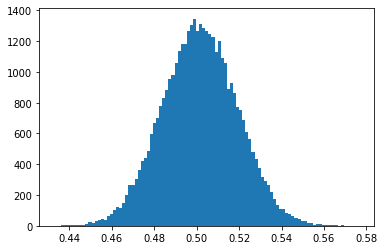

In [5]:
# QUICK ASIDE...
# Looking at distribution of means - we have many values that are trivially 0 or 1, need to fix this at
# the data generation stage...
import matplotlib.pyplot as plt
min_mean = min(means)
max_mean = max(means)
plt.hist(means, bins=np.arange(min_mean, max_mean, (max_mean-min_mean)/100))

# YAY! Adding Scaling factor to stdev improved histogram!

In [8]:
########## SECTION 3 -  ############################################
########## SECTION 2 - Generating Simulated Dataset ############################################

# Given a data sample (y_i, X_i), start by choosing a "fine grid" of kappas <= 1/2
kappaArray = np.arange(0.01,0.51,0.01)

# Initializing list to hold proportions of times MLE is found to exist at each kappa
kappaProportion = []

d1 = time.time()
# For each k_j in the grid, we do the following:
for kappa in kappaArray:
    
    # Set sample size to n_j =p / k_j (rounding off to nearest integer)
    sampleSize = int(round(p/kappa))

    # Here, we draw several samples and check to see if the MLE exists. B is the number of
    # rounds of sampling
    B = 10
    
    # nMleExist is the total number of times the MLE was found to exist during each round. This
    # is initially set to 0
    nMleExist = 0
    for i in range(B):
        print(i)
        subSample = df.sample(n=sampleSize) # draw the sample
        print(subSample.shape)
        mleStatus = checkMleExistence(subSample) # check if MLE exists
        # Note that checkMleExistence returns a coded value. The list of coded values can be
        # found here: https://www.gurobi.com/documentation/9.0/refman/optimization_status_codes.html
        # We are most interested in whether the model was proved to be infeasible, in which case, the
        # value 3 is returned. In this case we know the MLE exists and is unique.
        if mleStatus == 3:
            nMleExist +=1
            
    # Dividing nMleExist by B gives an estimate of the proportion of times the MLE exists.
    propMleExist = nMleExist/B
    kappaProportion.append(propMleExist)
    
    # QUESTION: AREN'T WE INTERESTED IN THE NUMBER OF TIMES MLE DOES NOT EXIST?

# Now, we need (kappa_j-1, kappa_j) such that kappa_j is the smallest value for which the proportion of times
# the MLE ... 
uIdx = next(i for i,v in enumerate(kappaProportion) if v >= 0.5)
uKappa = kappaArray[uIdx]
lKappa = kappaArray[uIdx-1]


d2 = time.time()
delta = round(d2 - d1)
print(kappaProportion, delta)

0
(20000, 202)


KeyError: 2